# Part 5: Crop Yield Prediction using LightGBM & Optuna

## 1. Executive Summary
This notebook focuses on training a gradient boosting model (**LightGBM**) to predict crop yields. We utilize a rigorous time-series validation strategy to ensure the model generalizes well to future years.

## 2. Methodology
1.  **Data Preparation:** Loading the engineered dataset and selecting a specific crop target.
2.  **Temporal Splitting:**
    * **Train (< 2016):** Historical data for model fitting.
    * **Validation (2016 - 2020):** Used for hyperparameter tuning and early stopping.
    * **Test (>= 2020):** "Unseen" future data for final performance reporting.
3.  **Benchmarking:** Establishing a naive baseline (Last Year's Yield) to benchmark ML performance.
4.  **Modeling & Tuning:**
    * Training an initial LightGBM model to check convergence.
    * Using **Optuna** (Bayesian Optimization) to tune hyperparameters (learning rate, depth, regularization).
5.  **Evaluation Metrics:**
    * **RMSE:** Root Mean Squared Error (Standard metric).
    * **R2:** Coefficient of Determination.
    * **RMSPE:** Root Mean Squared Percentage Error (New addition for relative error context).

In [1]:
# --- GLOBAL IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Added for geographic visualization

# Modeling
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score

# Optuna Visualization
from optuna.visualization import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_slice,
    plot_param_importances
)

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- HELPER FUNCTION: RMSPE ---
def rmspe(y_true, y_pred):
    """
    Calculate Root Mean Squared Percentage Error.
    Handling division by zero with a small epsilon.
    """
    epsilon = 1e-10
    # Ensure we don't divide by zero; percentage error formula
    pct_error = (y_true - y_pred) / (y_true + epsilon)
    return np.sqrt(np.mean(pct_error**2)) * 100

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Data Loading & Configuration
Here we load the dataset and define the target crop. The notebook is designed to be dynamic; changing `CHOSEN_CROP` updates the target variable and lag features automatically.

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- IDENTIFY AVAILABLE CROPS ---
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Filter rows where the target crop exists
df_model = df.dropna(subset=[TARGET_COL])
print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


## 4. Feature Engineering & Temporal Split
To prevent data leakage, we clean the feature set (removing yield history of *other* crops) and split the data strictly by year.

In [3]:
# --- DROP UNWANTED COLUMNS ---
# Remove yield history columns belonging to other crops to avoid noise/leakage
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Independent variables (exclude 'Y_' targets and metadata like 'area')
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Total Features Used: {len(feature_cols)}")

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (2014 - 2018)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")

Total Features Used: 23

Training Samples   (<2014)     : 3579
Validation Samples (2014-2018): 575
Testing Samples    (>=2019)    : 575


## 5. Baseline Model Evaluation
We calculate the performance of a naive predictor: **Yield(t) = Yield(t-1)**. Our machine learning models must beat these metrics to be considered useful.

In [4]:
# Baseline: Predict yield is exactly last year's yield
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation (in case lag feature is missing)
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

# Calculate Metrics
rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)
rmspe_baseline = rmspe(y_test_clean, y_pred_clean)

print(f"--- Baseline Metrics ---")
print(f"RMSE : {rmse_baseline:.2f}")
print(f"R2   : {r2_baseline:.4f}")
print(f"RMSPE: {rmspe_baseline:.2f}%")

--- Baseline Metrics ---
RMSE : 533.44
R2   : 0.9427
RMSPE: 14.32%


## 6. Initial Model & Learning Curve
We train a LightGBM model with default parameters to verify the pipeline works and inspect the learning curve for overfitting/underfitting.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5375
[LightGBM] [Info] Number of data points in the train set: 3579, number of used features: 23
[LightGBM] [Info] Start training from score 3365.356527
Training until validation scores don't improve for 50 rounds
[100]	Train's rmse: 363.947	Train's l2: 132457	Validation's rmse: 513.581	Validation's l2: 263765
Early stopping, best iteration is:
[96]	Train's rmse: 368.141	Train's l2: 135528	Validation's rmse: 512.693	Validation's l2: 262854

--- Initial Model Test Metrics ---
RMSE : 522.58
RMSPE: 18.25%


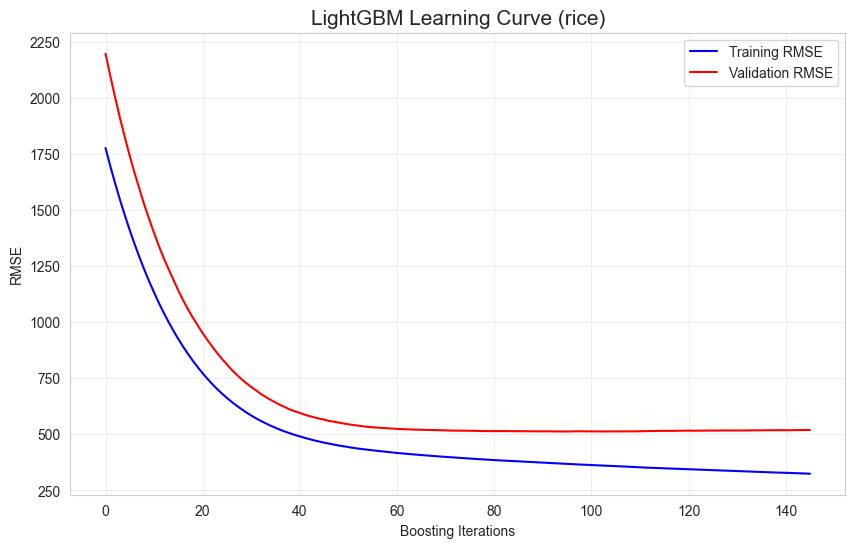

In [5]:
# 1. Initialize LightGBM with standard params
model_init = lgb.LGBMRegressor( 
    n_estimators=1000, 
    learning_rate=0.05, 
    num_leaves=31, 
    random_state=42, 
    n_jobs=-1 
)

# Dictionary to store training metrics
evals_result = {}

# 2. Train on TRAIN, Early Stop on VALIDATION
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_names=['Train', 'Validation'],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# 3. Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)
rmspe_init_test = rmspe(y_test, y_pred_init_test)

print(f"\n--- Initial Model Test Metrics ---")
print(f"RMSE : {rmse_init_test:.2f}")
print(f"RMSPE: {rmspe_init_test:.2f}%")

# 4. Plot Learning Curve
plt.figure(figsize=(10, 6))
train_metric = evals_result['Train']['rmse']
val_metric = evals_result['Validation']['rmse']
plt.plot(train_metric, label='Training RMSE', color='blue')
plt.plot(val_metric, label='Validation RMSE', color='red')
plt.title(f'LightGBM Learning Curve ({CHOSEN_CROP})', fontsize=15)
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Hyperparameter Optimization (Optuna)
We perform Bayesian Optimization to find the best hyperparameters (Learning Rate, Depth, Regularization) that minimize RMSE on the Validation set.

In [6]:
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.6),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_LGBM'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=30)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-29 14:41:17,188] A new study created in memory with name: Rice_Yield_LGBM
[I 2025-11-29 14:41:17,422] Trial 0 finished with value: 538.1178669351674 and parameters: {'learning_rate': 0.02521081527533216, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 81, 'subsample': 0.8128860380484509, 'colsample_bytree': 0.4410028921469028, 'reg_alpha': 0.0030710166970330174, 'reg_lambda': 4.285990127713166e-05}. Best is trial 0 with value: 538.1178669351674.
[I 2025-11-29 14:41:17,516] Trial 1 finished with value: 535.6200570998714 and parameters: {'learning_rate': 0.037146590737814525, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.7109548093735785, 'colsample_bytree': 0.5323184269133772, 'reg_alpha': 0.01955035162622595, 'reg_lambda': 7.869747906788012e-08}. Best is trial 1 with value: 535.6200570998714.
[I 2025-11-29 14:41:17,624] Trial 2 finished with value: 540.2866826259074 and parameters: {'learning_rate': 0.05123915198073304, 'num_leaves': 23, 


Best Parameters found:
{'learning_rate': 0.055845547095908665, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9593207926411045, 'colsample_bytree': 0.5985814818523343, 'reg_alpha': 4.3739239072056086e-05, 'reg_lambda': 0.2644209227455392}


## 8. Optuna Analysis
Visualizing the optimization history and parameter importance to understand what drives model performance.

In [7]:
# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinates (Hyperparameter interactions)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'Hyperparameter Relationships', width=900, height=500)
fig.show()

# 3. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'Hyperparameter Importance', width=900, height=500)
    fig.show()
except Exception as e:
    print(f'Could not plot parameter importance: {e}')

## 9. Final Model Training
We retrain the model using the **Best Parameters** found by Optuna. To maximize data utility, we combine the Training and Validation sets for this final training phase.

In [8]:
# 1. Combine Train + Validation for Final Training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 2. Apply Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMRegressor(**best_params)

# 3. Train on Full History, Validate on Test (for early stopping ref only)
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# 4. Final Prediction on TEST Data
y_pred_final_test = final_model.predict(X_test)

# 5. Calculate Final Metrics
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)
rmspe_final_test = rmspe(y_test, y_pred_final_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	training's rmse: 398.443	training's l2: 158757	valid_1's rmse: 494.158	valid_1's l2: 244192


## 10. Final Results & Visualization
Comparing the Baseline, Initial, and Tuned models across RMSE and RMSPE.

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=533.44 | RMSPE=14.32%
Initial Model:  RMSE=522.58 | RMSPE=18.25%
Tuned Model:    RMSE=494.16 | RMSPE=15.00%
 Improvement:    7.36% reduction in RMSE


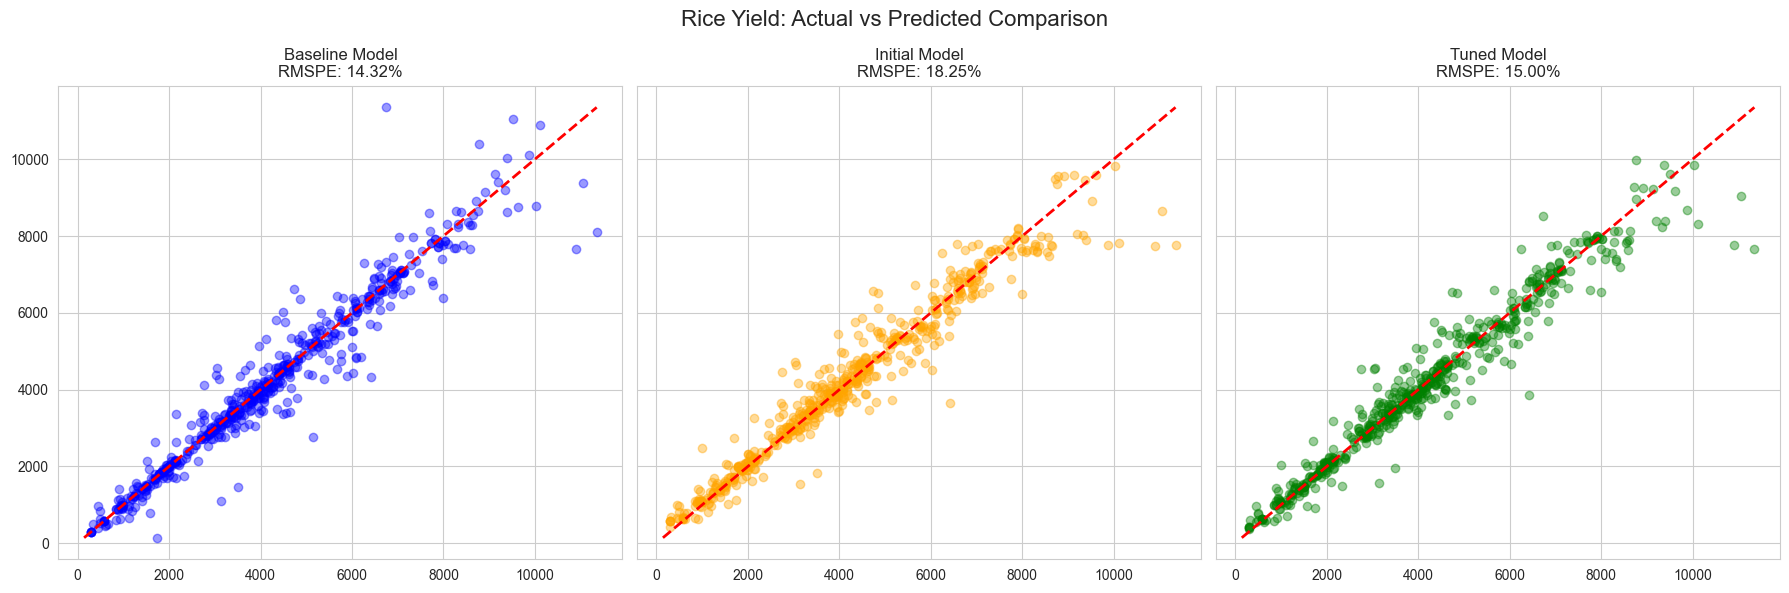

In [9]:
# Calculate Improvement % relative to Baseline
imp_rmse = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f} | RMSPE={rmspe_baseline:.2f}%")
print(f"Initial Model:  RMSE={rmse_init_test:.2f} | RMSPE={rmspe_init_test:.2f}%")
print(f"Tuned Model:    RMSE={rmse_final_test:.2f} | RMSPE={rmspe_final_test:.2f}%")
print(f" Improvement:    {imp_rmse:.2f}% reduction in RMSE")

# --- PLOTTING ACTUAL VS PREDICTED ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Determine axis limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSPE: {rmspe_baseline:.2f}%')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial Model\nRMSPE: {rmspe_init_test:.2f}%')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned Model\nRMSPE: {rmspe_final_test:.2f}%')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Actual vs Predicted Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## 11. Feature Importance
Identifying which features contributed most to the predictions using 'Gain' (information gain).


--- Top 10 Features by Gain ---
             Feature          Gain
0  avg_yield_rice_1y  6.290543e+10
1  avg_yield_rice_3y  5.290002e+10
2  avg_yield_rice_5y  9.002501e+09
3    fertilizer_lag1  2.221691e+09
4           latitude  1.957395e+09
5    avg_temp_winter  1.934077e+09
6    avg_temp_spring  9.928625e+08
7   avg_solar_annual  7.347556e+08
8   avg_solar_autumn  4.477661e+08
9          longitude  4.024867e+08


C:\Users\PavinP\AppData\Local\Temp\ipykernel_3776\2839986950.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




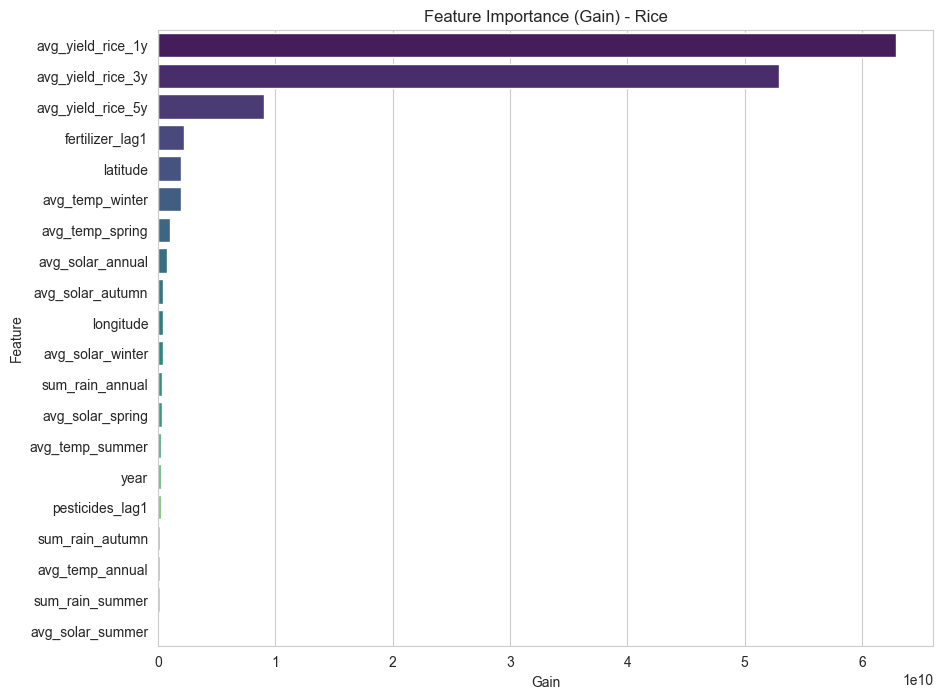

In [10]:
# Extract importance
importances = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.feature_name_

# Create DataFrame
fi_df = pd.DataFrame({'Feature': feature_names, 'Gain': importances})
fi_df = fi_df.sort_values(by='Gain', ascending=False).reset_index(drop=True)

print("\n--- Top 10 Features by Gain ---")
print(fi_df.head(10))

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Gain', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance (Gain) - {CHOSEN_CROP.capitalize()}')
plt.show()

## 12. Timeline Analysis
Visualizing predictions over the full timeline to see how the model handles the transition from historical data to future forecasting.

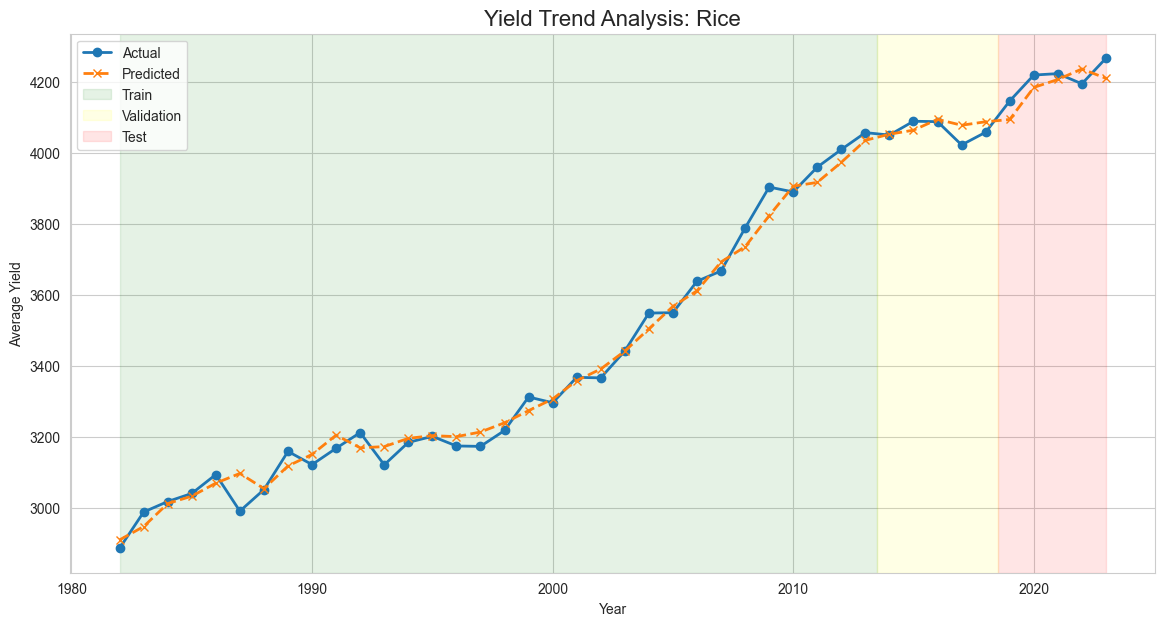

In [11]:
# 1. Generate Full Predictions
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Aggregate by Year
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})
yearly_trend = df_full_trend.groupby('Year').mean()

# 3. Plot
plt.figure(figsize=(14, 7))
plt.plot(yearly_trend.index, yearly_trend['Actual'], marker='o', label='Actual', linewidth=2)
plt.plot(yearly_trend.index, yearly_trend['Predicted'], marker='x', linestyle='--', label='Predicted', linewidth=2)

# Highlight Regions
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5
plt.axvspan(yearly_trend.index.min(), train_boundary, color='green', alpha=0.1, label='Train')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label='Validation')
plt.axvspan(val_boundary, yearly_trend.index.max(), color='red', alpha=0.1, label='Test')

plt.title(f'Yield Trend Analysis: {CHOSEN_CROP.capitalize()}', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.legend()
plt.show()

## 13. Geographic Error Distribution
We analyze the prediction error (**RMSPE**) by country to identify regions where the model performs poorly.

In [12]:
# 1. Prepare Data
mask_test = df_model['year'] >= VAL_END_YEAR
test_set_context = df_model[mask_test][['area', 'year']].copy()

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
}).join(test_set_context)

# 2. Standardize Country Names for Plotly
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'China,_mainland': 'China',
    'United_Republic_of_Tanzania': 'Tanzania',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran'
})

# 3. Aggregate Error by Country
epsilon = 1e-10
comparison_df['Sq_Pct_Error'] = (
    (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
    (comparison_df['Actual_Value'] + epsilon)
) ** 2

country_stats = comparison_df.groupby('area').agg(
    RMSPE=('Sq_Pct_Error', lambda x: np.sqrt(x.mean()) * 100),
    Avg_Actual=('Actual_Value', 'mean'),
    Avg_Pred=('Predicted_Value', 'mean')
).reset_index().rename(columns={'area': 'Country'})

# 4. Plot Map
fig = px.choropleth(
    country_stats,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'yellow', 'red'],
    range_color=[0, 50],  # Cap scale at 50% error for visibility
    title=f'Geographic Error Distribution (RMSPE) - {CHOSEN_CROP.capitalize()}',
    hover_data={'RMSPE': ':.2f', 'Avg_Actual': ':.0f', 'Avg_Pred': ':.0f'}
)
fig.update_layout(geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'))
fig.show()

C:\Users\PavinP\AppData\Local\Temp\ipykernel_3776\2811239463.py:36: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.

